<a href="https://colab.research.google.com/github/myngoc-trg/BERN02_Project_Credit_Risk/blob/main/Project/BERN02_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Librarries**

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
import shap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# **Importing Data**

In [ ]:
url = "https://raw.githubusercontent.com/myngoc-trg/STAN48-Programming-for-Data-Science/refs/heads/main/Final%20Project/Data/cleaned_credit_risk_dataset.csv"


df = pd.read_csv(url,index_col=0)

# Display the first few rows
df.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
1,21,9600,5.0,1,1000,11.14,0,0.10,0,2,0,1,0,0,0,0,0,0
2,25,9600,1.0,2,5500,12.87,1,0.57,0,3,1,0,0,1,0,0,0,0
3,23,65500,4.0,2,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,0
4,24,54400,8.0,2,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,0
5,21,9900,2.0,0,2500,7.14,1,0.25,0,2,0,1,0,0,1,0,0,0


**Data verification**

Examination of input data shape and possible NaNs in the respective collumns.

In [ ]:
df.info()
df.describe()
df.columns
df.isna().sum()
df['loan_status'].value_counts().reset_index()

<class 'pandas.core.frame.DataFrame'>
Index: 32409 entries, 1 to 32580
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32409 non-null  int64  
 1   person_income                   32409 non-null  int64  
 2   person_emp_length               32409 non-null  float64
 3   loan_grade                      32409 non-null  int64  
 4   loan_amnt                       32409 non-null  int64  
 5   loan_int_rate                   32409 non-null  float64
 6   loan_status                     32409 non-null  int64  
 7   loan_percent_income             32409 non-null  float64
 8   cb_person_default_on_file       32409 non-null  int64  
 9   cb_person_cred_hist_length      32409 non-null  int64  
 10  person_home_ownership_MORTGAGE  32409 non-null  int64  
 11  person_home_ownership_OWN       32409 non-null  int64  
 12  person_home_ownership_OTHER     32409

,loan_status,count
0,0,25321
1,1,7088


# **VIF Filtration and Correlation**

Filtration of input variables following a target of minimizing input data collinearity.

In [ ]:
#VIF
X_data = df.loc[:, df.columns != 'loan_status']
X_data.head()


#Compute VIF

vif_data = pd.DataFrame()

vif_data["feature"] = X_data.columns

vif_data["VIF"] = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]

vif_data

,feature,VIF
0,person_age,55.300334
1,person_income,4.570513
2,person_emp_length,2.689804
3,loan_grade,11.818715
4,loan_amnt,8.360798
5,loan_int_rate,55.762903
6,loan_percent_income,8.439871
7,cb_person_default_on_file,1.710583
8,cb_person_cred_hist_length,9.865118
9,person_home_ownership_MORTGAGE,2.077618


In [ ]:
vif_filteredData = vif_data[vif_data['VIF']<10]

nummeric_columns = vif_filteredData['feature'].astype(str).tolist()


filtered_data = df[nummeric_columns]

#filtered_data.head()

filtered_data.shape

(32409, 14)

Examination using a correlation matrix of the filtered input variable following the VIF limit.

Text(0.5, 1.0, 'Correlation Matrix')

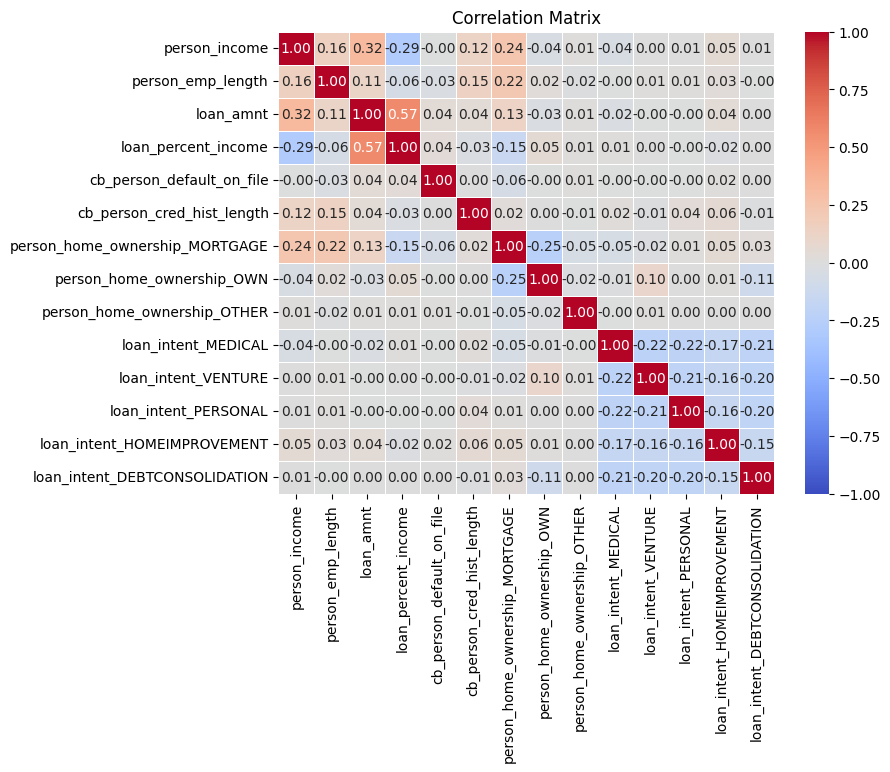

In [ ]:
corr_matrix = filtered_data.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths = 0.5, vmin = -1, vmax =1)

plt.title('Correlation Matrix')

# **PCA and TSNE**

Preprocessing data for PCA implementation.

In [ ]:
data_to_scale = X_data.drop(['cb_person_default_on_file','person_home_ownership_MORTGAGE','person_home_ownership_OWN','person_home_ownership_OTHER','loan_intent_MEDICAL','loan_intent_VENTURE','loan_intent_PERSONAL','loan_intent_HOMEIMPROVEMENT','loan_intent_DEBTCONSOLIDATION'], axis=1)
data_to_scale.head()
data_to_scale.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_data.shape, scaled_data

#Pd dataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df.head(), scaled_df.shape




(   person_age  person_income  person_emp_length  loan_grade  loan_amnt  \
 0   -1.083796      -1.071924           0.059888   -0.188863  -1.359401   
 1   -0.439710      -1.071924          -0.944205    0.667799  -0.647465   
 2   -0.761753      -0.007508          -0.191135    0.667799   4.019675   
 3   -0.600732      -0.218867           0.812958    0.667799   4.019675   
 4   -1.083796      -1.066211          -0.693182   -1.045525  -1.122089   
 
    loan_int_rate  loan_percent_income  cb_person_cred_hist_length  
 0       0.038514            -0.657856                   -0.939218  
 1       0.575703             3.743580                   -0.692782  
 2       1.308516             3.368990                   -0.939218  
 3       1.010422             3.556285                   -0.446345  
 4      -1.203542             0.746857                   -0.939218  ,
 (32409, 8))

In [ ]:
scaled_data_combined = pd.concat([scaled_df, X_data[['cb_person_default_on_file','person_home_ownership_MORTGAGE','person_home_ownership_OWN','person_home_ownership_OTHER','loan_intent_MEDICAL','loan_intent_VENTURE','loan_intent_PERSONAL','loan_intent_HOMEIMPROVEMENT','loan_intent_DEBTCONSOLIDATION']].reset_index(drop=True)], axis=1)
scaled_data_combined.head()


,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
0,-1.083796,-1.071924,0.059888,-0.188863,-1.359401,0.038514,-0.657856,-0.939218,0,0,1,0,0,0,0,0,0
1,-0.439710,-1.071924,-0.944205,0.667799,-0.647465,0.575703,3.743580,-0.692782,0,1,0,0,1,0,0,0,0
2,-0.761753,-0.007508,-0.191135,0.667799,4.019675,1.308516,3.368990,-0.939218,0,0,0,0,1,0,0,0,0
3,-0.600732,-0.218867,0.812958,0.667799,4.019675,1.010422,3.556285,-0.446345,1,0,0,0,1,0,0,0,0
4,-1.083796,-1.066211,-0.693182,-1.045525,-1.122089,-1.203542,0.746857,-0.939218,0,0,1,0,0,1,0,0,0


Implementation of PCA and examination of principal components.

In [ ]:
pca = PCA(n_components=17)  # choose top 3 PCs for visualization
X_pca = pca.fit_transform(scaled_data_combined)

#df['PCA1'], df['PCA2'], df['PCA3'] = X_pca[:,0], X_pca[:,1], X_pca[:,2]

In [ ]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("\nCumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))


Explained variance ratio: [0.23210207 0.22067297 0.15915349 0.13569257 0.0957935  0.02580859
 0.01998743 0.01940505 0.0186087  0.0177225  0.01352457 0.01283622
 0.01137901 0.00698913 0.00656465 0.00340422 0.00035532]

Cumulative explained variance ratio: [0.23210207 0.45277504 0.61192853 0.74762111 0.8434146  0.86922319
 0.88921062 0.90861567 0.92722437 0.94494688 0.95847145 0.97130766
 0.98268667 0.9896758  0.99624045 0.99964468 1.        ]


**PCA component visualization**

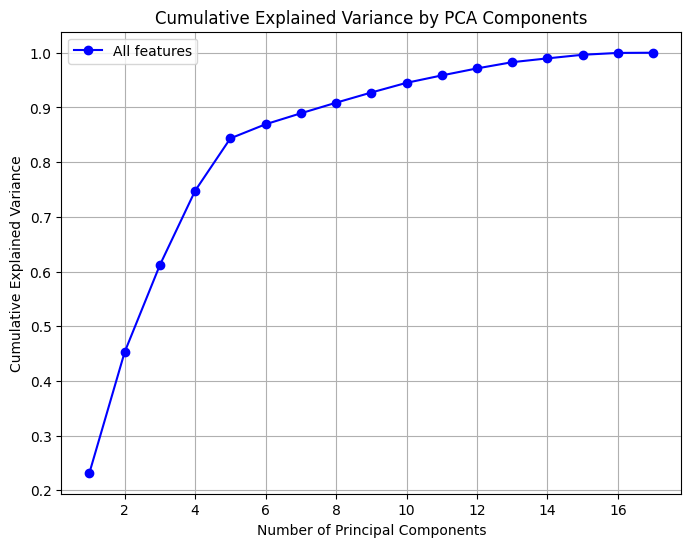

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_var)+1), cum_var, marker='o', c='b', label='All features')


plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

**tSNE**

tSNE input data numeric and finite verification as well as implementation of tSNE

In [ ]:
#t-SNE


#VIF filtered
# Ensure numeric and finite:
X = filtered_data.select_dtypes(include=[np.number]).T.to_numpy(dtype=float)
X = np.asarray(X, dtype=float)

#print('X:' ,X.shape)
#print('X:' ,len(filtered_data))

tsne = TSNE(
    n_components=2,
    perplexity=12,
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=250,                      # <- was max_iter
    n_iter_without_progress=300,
    min_grad_norm=1e-7,
    metric='euclidean',
    init='pca',
    verbose=0,
    random_state=42,                  # set for reproducibility (optional)
    method='barnes_hut',
    angle=0.5
)

reducedMap = tsne.fit_transform(filtered_data)



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:

features = scaled_data_combined


#df = filtered_data
target = df['loan_status']
target.shape, features.shape

((32409,), (32409, 17))

**t-SNE low dimensional projection**

In [ ]:
print(len(reducedMap))
plt.figure(figsize=(8, 6))
plt.scatter(reducedMap[:, 0], reducedMap[:, 1], s=40, alpha=0.7, edgecolors='k')
plt.title("t-SNE 2D Projection")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


# **Data balancing**

Generating new data based on provided data through the SMOTE operation.

In [ ]:
## DATA BALANCING
from imblearn.over_sampling import SMOTE
smote = SMOTE()
balanced_features, balanced_target = smote.fit_resample(features,target)
balanced_features.shape, balanced_target.shape

((50642, 17), (50642,))

The cell underneath is optional if the desire is to only include VIF filtered features into the Random Forest classifier.

In [ ]:
#VIF + balancing


#balanced_features = balanced_features[nummeric_columns] # uncomment this row if you only want to include VIF filtered collumns

balanced_features.shape


(50642, 17)

In [ ]:
balanced_target_df = pd.DataFrame({'target':balanced_target})
balanced_target_df.groupby('target').value_counts().reset_index()

,target,count
0,0,25321
1,1,25321


# **Random Forest Model**

Train and test random split of the balanced data following a ratio corresponding to 20% test data and 80% training data.

In [ ]:
RANDOM_STATE = 42

x_train, x_test, y_train, y_test = train_test_split(balanced_features, balanced_target, test_size=0.2, random_state=RANDOM_STATE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((40513, 17), (10129, 17), (40513,), (10129,))

In [ ]:
x_train.shape, x_test.shape #14 collumns = correct

((40513, 17), (10129, 17))

**Grid-search and evaluation Methods**

Implementation of k-fold grid search classification and evaluation of classification using selected statistical measures such as scoring, feature importance, and Shapley values.

In [ ]:
# Function to run grid search and return the best estimator
def grid_search(x_train, y_train, n_depths_range, n_estimators_range, min_leaf_samples_range, k_folds, classifier, score = "accuracy"):
    kfold5 = KFold(k_folds, random_state=1, shuffle=True)
    params = {}
    if n_depths_range is not None:
        params['max_depth'] = n_depths_range
    if n_estimators_range is not None:
        params['n_estimators'] = n_estimators_range
    if min_leaf_samples_range is not None:
        params['min_samples_leaf'] = min_leaf_samples_range

    rfc_gscv = GridSearchCV(classifier, param_grid = params, scoring = score,
                                cv = kfold5, n_jobs=-1,)
    # Fit the model
    model_rfc = rfc_gscv.fit(x_train, y_train)

    # Model best estimator
    #max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
    #max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
    #max_cvs= rfc_gscv.best_score_
    best_rf = rfc_gscv.best_estimator_
    print("Best params:", rfc_gscv.best_params_)
    print("CV score:", rfc_gscv.best_score_)
    return best_rf, rfc_gscv


# Model evaluation
def evaluate_model(model, x_train, x_test, y_train, y_test, confusion_matrix=True, calc_shap=True):
    # Analysis of best estimator
    score_rfc_train = accuracy_score(y_train, model.predict(x_train))
    score_rfc_test = accuracy_score(y_test, model.predict(x_test))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))

    folds = KFold()

    score_cv_train = cross_val_score(model, x_train, y_train, cv=folds)
    #score_cv_test = cross_val_score(model, x_test, y_test, cv=folds)

    print("Average accuracy of the model on cross validation of train data: %0.4f ( %0.2f)" % (score_cv_train.mean(), score_cv_train.std()))
    #print("Average accuracy of the model on cross validation of test data: %0.4f ( %0.2f)" % (score_cv_test.mean(), score_cv_test.std()))

    print("\nClassification Report:")
    print(classification_report(y_test, model.predict(x_test)))

    if confusion_matrix:
        labelset = list(set(y_test))
        if len(labelset) < len(list(set(y_train))):
            labelset = list(set(y_train))
        ConfusionMatrixDisplay.from_estimator(
            model, x_test, y_test, display_labels=labelset
        )
        plt.show()

    # Feature importances
    feature_imp = pd.DataFrame(
        {'importance':model.feature_importances_},
        index=x_train.columns)
    print("Feature importances on the best random forest estimator")
    print(feature_imp.sort_values(by='importance', ascending=False))

    # Shap values
    if calc_shap:
        explainer = shap.Explainer(model.predict, x_test)
        shap_values = explainer(x_test)
        shap.summary_plot(shap_values)

**Running model**

In [ ]:
#gridsearch

# Try gridsearch without using the pretrained model
k_folds = 5
n_depths_range = np.arange(18, 30, 1, dtype=np.int16)
n_estimators_range = np.arange(10, 30, 5, dtype=np.int16) # CV number of trees (estimators) 10, 20, ..., 100
min_leaf_samples_range = np.arange(1, 6, 2, dtype=np.int16)

best_rf, g_model = grid_search(x_train, y_train, n_depths_range, n_estimators_range, min_leaf_samples_range, k_folds, RandomForestClassifier(), score='accuracy')

Best params: {'max_depth': np.int16(29), 'min_samples_leaf': np.int16(1), 'n_estimators': np.int16(25)}
CV score: 0.9362920218771809


**Evaluating Model**

Accuracy of RandomForestClassifier on train data: 0.9995
Accuracy of RandomForestClassifier on test data: 0.9404
Average accuracy of the model on cross validation of train data: 0.9357 ( 0.00)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5086
           1       0.97      0.91      0.94      5043

    accuracy                           0.94     10129
   macro avg       0.94      0.94      0.94     10129
weighted avg       0.94      0.94      0.94     10129



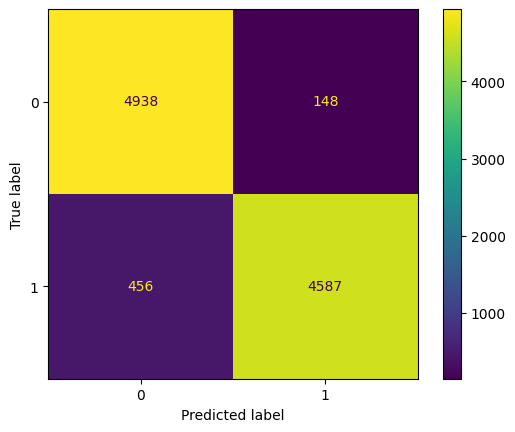

Feature importances on the best random forest estimator
                                importance
loan_percent_income               0.201969
person_income                     0.134255
loan_grade                        0.131503
loan_int_rate                     0.127074
loan_amnt                         0.076029
person_emp_length                 0.062042
cb_person_cred_hist_length        0.058602
person_home_ownership_MORTGAGE    0.052262
person_age                        0.051821
person_home_ownership_OWN         0.032828
loan_intent_HOMEIMPROVEMENT       0.014660
loan_intent_MEDICAL               0.013803
loan_intent_DEBTCONSOLIDATION     0.012584
loan_intent_VENTURE               0.012427
cb_person_default_on_file         0.009191
loan_intent_PERSONAL              0.008558
person_home_ownership_OTHER       0.000391


PermutationExplainer explainer: 10130it [25:04,  6.69it/s]
/tmp/ipython-input-941987073.py:66: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values)


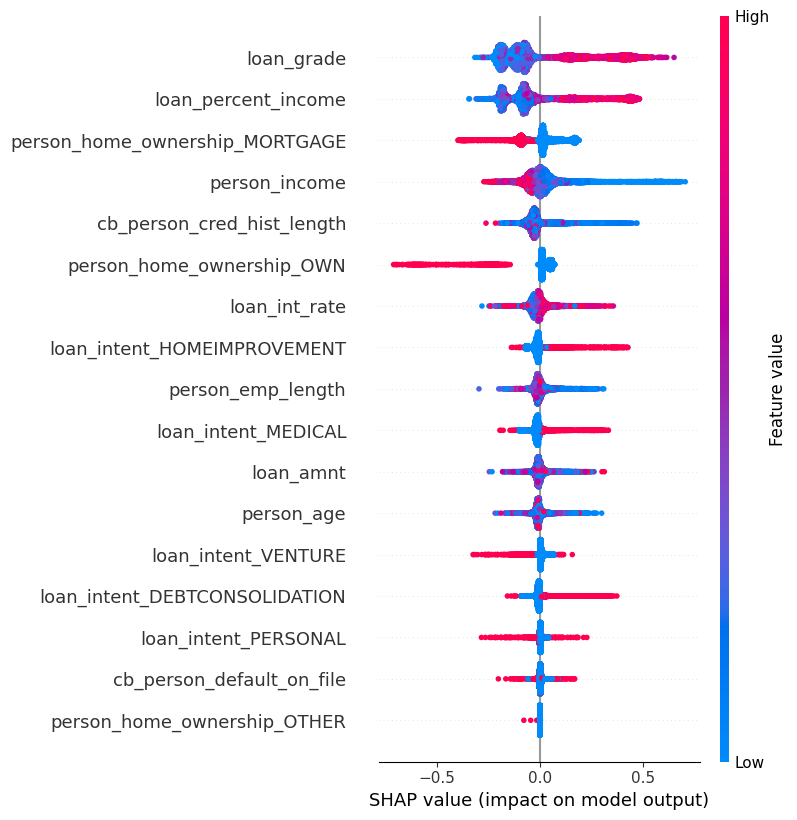

In [ ]:
evaluate_model(best_rf, x_train, x_test, y_train, y_test, confusion_matrix=True, calc_shap=True) #Will take long time with calc_shap = True [Expected runtime 30 min]


# **Neural Networks**

Train and test random split of the balanced data following a ratio corresponding to 20% test data and 80% training data.

In [ ]:
#This would be an automatic way to split the data
x_train,x_valid,y_train,y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
# test the shape
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((32410, 17), (8103, 17), (32410,), (8103,))

**Model Definition**

Construction of a three-layer fully connected feedforward network using the LeakyReLU as activation function and a layer-based dropout.

In [ ]:

# Define the model
model = Sequential([
    Dense(128, input_shape=(x_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(32),
    LeakyReLU(alpha=0.01),

    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # stop if val_loss doesn’t improve after 5 epochs
    restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,706 (49.63 KB)

 Trainable params: 12,706 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Implementation of the Neural network.

In [ ]:
batch_size = 64 # load this many
epochs = 100    # Total throughput
num_classes = 2

default_train = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid, y_valid), callbacks=[early_stop])
model.save("default_model0.h5")

NameError: name 'model' is not defined

**Evaluation**

Test loss: 0.26989203691482544
Test accuracy: 0.8707671165466309


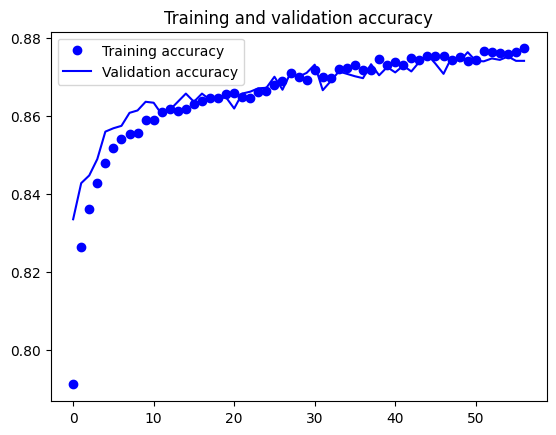

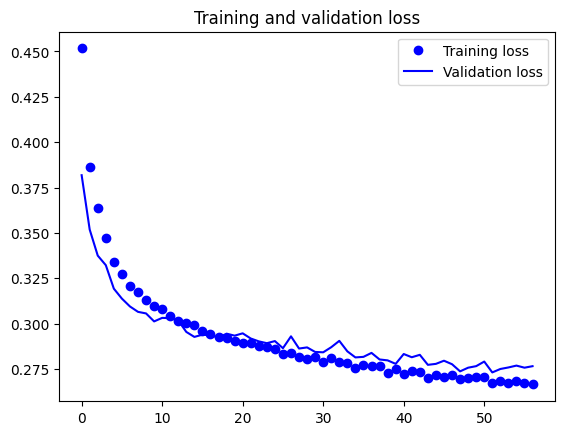

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = default_train.history['accuracy']
val_accuracy = default_train.history['val_accuracy']
loss = default_train.history['loss']
val_loss = default_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test loss: 0.26989203691482544
Test accuracy: 0.8707671165466309


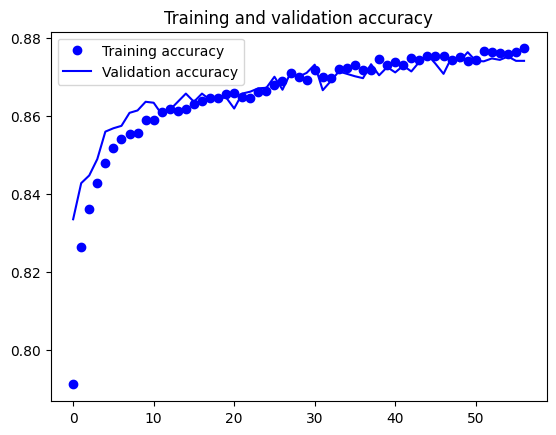

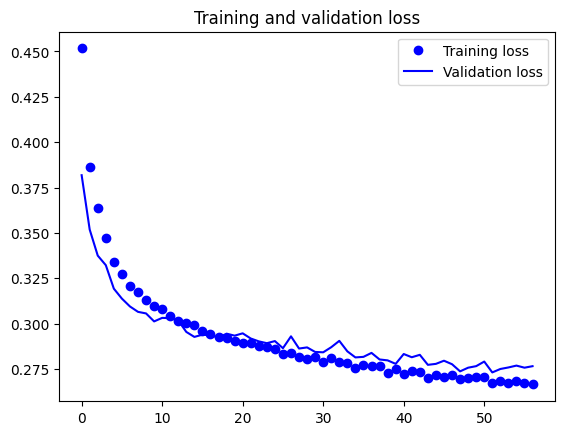

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = default_train.history['accuracy']
val_accuracy = default_train.history['val_accuracy']
loss = default_train.history['loss']
val_loss = default_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[4825  261]
 [1048 3995]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      5086
           1       0.94      0.79      0.86      5043

    accuracy                           0.87     10129
   macro avg       0.88      0.87      0.87     10129
weighted avg       0.88      0.87      0.87     10129



# **Neural Networks 2**

Similar to Neural Netowrks 1 with the exception of having a four-layer network in this case and dynamic layer-based dropout.

**Model Definition**

In [ ]:
# Define the model
model1 = Sequential([
    Dense(128, kernel_initializer='he_normal',input_shape=(x_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2), #0.4

    Dense(64, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.1),

    Dense(32, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.05),

    Dense(16, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),

    Dense(2, activation='softmax')  # binary classification (2 classes)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1,
    mode='min',
    min_lr=1e-5
)
model1.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,162 (55.32 KB)

 Trainable params: 13,682 (53.45 KB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
batch_size = 64 # load this many
epochs = 100    # Total throughput
num_classes = 2

default_train1 = model1.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid, y_valid), callbacks=[early_stop, reduce_lr])
model.save("default_model1.h5")

Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7463 - loss: 0.5311 - val_accuracy: 0.8225 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8115 - loss: 0.4113 - val_accuracy: 0.8387 - val_loss: 0.3549 - learning_rate: 0.0010
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8230 - loss: 0.3898 - val_accuracy: 0.8466 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8295 - loss: 0.3759 - val_accuracy: 0.8503 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 5/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8359 - loss: 0.3674 - val_accuracy: 0.8508 - val_loss: 0.3206 - learning_rate: 0.0010
Epoch 6/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8398 - loss: 0.3565 - val_accuracy: 0.8556 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 7/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8418 - loss: 

**Evaluation**

Test loss: 0.27351775765419006
Test accuracy: 0.8686938285827637


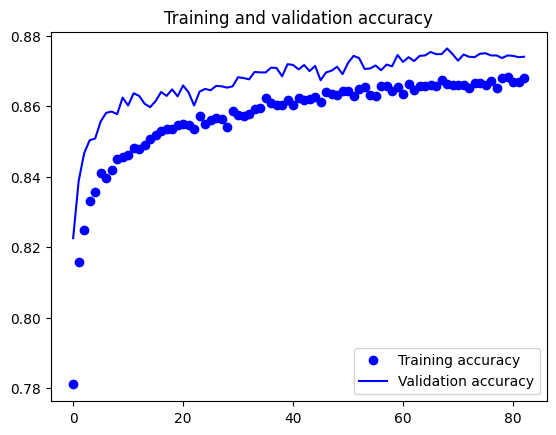

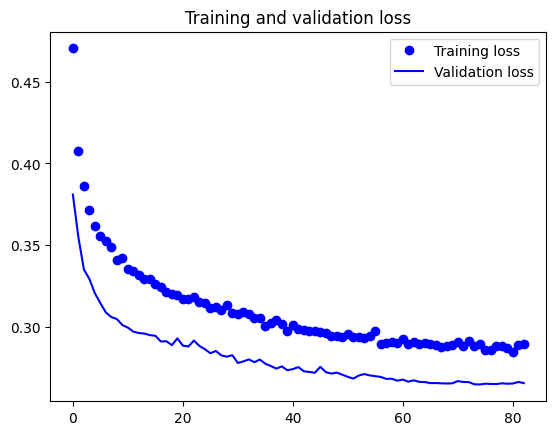

In [ ]:
test_eval = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = default_train1.history['accuracy']
val_accuracy = default_train1.history['val_accuracy']
loss = default_train1.history['loss']
val_loss = default_train1.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob = model1.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[4747  339]
 [ 991 4052]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      5086
           1       0.92      0.80      0.86      5043

    accuracy                           0.87     10129
   macro avg       0.88      0.87      0.87     10129
weighted avg       0.87      0.87      0.87     10129



# **FAIR principles**

This project alligns with the FAIR principles following the four key points.

The project is seen as findable as it is published on GitHub through which a public URL will be created for this project, thus allowing for world wide access of the project.

Furthermore, this alligns with the second key point which is for the project to be accessible where the project will in addition be provided a BSD 3 Clause to allow for further development. The associated data together with the package dependencies will be provided on the GITHUB page to ensure interoperablity of the project.

In the case of the Grid-Search Random forest classification the use of methods, alligning with a object orientated workflow, has been carefully choosen to make these parts easily interoperable in other similar projects.

The project is also considered reusable as the publication of the project will contain the original data and comments are carfully written throughout the project.

fatal: not a git repository (or any of the parent directories): .git
